In [120]:
import os
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy

from tensorflow import keras

In [121]:
def load_expert_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.loads(f.read())
        o = data['observations']
        a = data['actions']
    return (o, a)

In [122]:
# Generate 10 rollouts of expert data 
tasks = ['Hopper-v2', 'Ant-v2', 'HalfCheetah-v2', 'Humanoid-v2', 'Reacher-v2', 'Walker2d-v2']
num_rollouts = 10
for task in tasks: 
    filename='experts/'+ task +'.pkl';
    from subprocess import call
    call(["python", "run_expert.py", filename, task, "--num_rollouts="+str(num_rollouts)])

In [123]:
for task in tasks: 
    filename='expert_data/'+ task +'.pkl';
    o, a = load_expert_data(filename)
    print(o.shape)
    print(a.shape)

(10000, 11)
(10000, 1, 3)
(10000, 111)
(10000, 1, 8)
(10000, 17)
(10000, 1, 6)
(10000, 376)
(10000, 1, 17)
(500, 11)
(500, 1, 2)
(10000, 17)
(10000, 1, 6)


In [124]:
def create_model(o, a):
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, o.shape[1]])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, a.shape[1]])

    dim = 256
    # create variables
    W0 = tf.get_variable(name='W0', shape=[o.shape[1], dim], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[dim, dim], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[dim, a.shape[1]], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[dim], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[dim], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[a.shape[1]], initializer=tf.constant_initializer(0.))

    weights = [W0, W1, W2]
    biases = [b0, b1, b2]
    activations = [tf.nn.relu, tf.nn.relu, None]
    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
    output_pred = layer

    return input_ph, output_ph, output_pred

In [183]:
def test_run(model, num_rollouts, task, expert_policy=False, max_steps = 1000000):
    render = False
    import gym
    env = gym.make(task)
    max_steps = max_steps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(num_rollouts):
        #print('test_run rollout', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = model(obs[None,:])

            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if render:
                env.render()
            #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                break
        returns.append(totalr)

    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return %lf'%np.std(returns))

    data = {'observations': np.array(observations),
                   'actions': np.array(actions),
                   'returns' : returns
                   }
    #return (np.mean(returns), np.std(returns))
    return data

In [126]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [127]:
# BC model 
def train_model(task, epochs):
    filename='expert_data/'+ task +'.pkl';
    print("Training for {}.".format(filename))
    o, a = load_expert_data(filename)
    a = a.reshape(a.shape[0], -1)
    train_ratio = 1.0
    valid_ratio = 0
    test_ratio = 0 
    train_index = int( train_ratio* o.shape[0])
    valid_index = int( valid_ratio* o.shape[0]) + train_index

    indices = np.random.permutation(o.shape[0])
    train_indices, valid_indices, test_indices = indices[:train_index], indices[train_index:valid_index], indices[valid_index:]
    o_train, o_valid, o_test = o[train_indices], o[valid_indices], o[test_indices]
    a_train, a_valid, a_test = a[train_indices], a[valid_indices], a[test_indices]
    print(o_train.shape)
    print(o_valid.shape)
    print(o_test.shape)
    model_name = task +'ckpt'
    
    tf_reset()
    with tf.Session() as sess:
        input_ph, output_ph, output_pred = create_model(o_train, a_train)

        try:
            saver = tf.train.Saver()
            saver.restore(sess, "/tmp/1"+model_name)
        except ValueError:
            # create loss
            mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))

            # create optimizer
            opt = tf.train.AdamOptimizer().minimize(mse)

            # initialize variables
            sess.run(tf.global_variables_initializer())
            # create saver to save model variables
            saver = tf.train.Saver()

            # run training
            batch_size = 64
            iterations = o_train.shape[0] // batch_size
            # run BC training
            for epoch_step in range(epochs):
                for training_step in range(iterations):
                    #print("training step %d" % training_step)
                    # get a random subset of the training data
                    indices = np.random.randint(low=0, high=o_train.shape[0], size=batch_size)
                    input_batch = o_train[indices]
                    output_batch = a_train[indices]

                    # run the optimizer and get the mse
                    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})

                # print the mse every so often
                print('epochs {0:02d} mse: {1:.3f}'.format(epoch_step, mse_run))
            saver.save(sess, '/tmp/'+model_name)
    
    #tf_reset()    
        my_model = tf_util.function([input_ph], output_pred)
        model_data = test_run(my_model, num_rollouts, task, expert_policy=False)

    tf_reset()
    with tf.Session() as sess:
        policy_fn = load_policy.load_policy('experts/'+task+'.pkl')
        ref_data = test_run(policy_fn, num_rollouts, task, expert_policy=True)

    model_mean, model_std = (np.mean(model_data['returns']), np.std(model_data['returns']))
    ref_mean, ref_std =  (np.mean(ref_data['returns']), np.std(ref_data['returns']))
    print(model_mean, ref_mean)
    print(model_std, ref_std)
    return (model_mean, ref_mean), (model_std, ref_std)

In [128]:
epochs = 40
part2_2 = {}
tasks = ['Hopper-v2', 'Ant-v2', 'HalfCheetah-v2', 'Humanoid-v2', 'Reacher-v2', 'Walker2d-v2']

#tasks = ['Hopper-v2']
for task in tasks:
    part2_2[task] = train_model(task, epochs)
print(part2_2)

Training for expert_data/Hopper-v2.pkl.
(10000, 11)
(0, 11)
(0, 11)
epochs 00 mse: 0.013
epochs 01 mse: 0.011
epochs 02 mse: 0.008
epochs 03 mse: 0.009
epochs 04 mse: 0.005
epochs 05 mse: 0.005
epochs 06 mse: 0.005
epochs 07 mse: 0.004
epochs 08 mse: 0.003
epochs 09 mse: 0.003
epochs 10 mse: 0.002
epochs 11 mse: 0.003
epochs 12 mse: 0.003
epochs 13 mse: 0.002
epochs 14 mse: 0.001
epochs 15 mse: 0.002
epochs 16 mse: 0.002
epochs 17 mse: 0.001
epochs 18 mse: 0.001
epochs 19 mse: 0.001
epochs 20 mse: 0.001
epochs 21 mse: 0.001
epochs 22 mse: 0.001
epochs 23 mse: 0.004
epochs 24 mse: 0.001
epochs 25 mse: 0.001
epochs 26 mse: 0.001
epochs 27 mse: 0.001
epochs 28 mse: 0.001
epochs 29 mse: 0.001
epochs 30 mse: 0.001
epochs 31 mse: 0.002
epochs 32 mse: 0.001
epochs 33 mse: 0.001
epochs 34 mse: 0.001
epochs 35 mse: 0.001
epochs 36 mse: 0.003
epochs 37 mse: 0.001
epochs 38 mse: 0.001
epochs 39 mse: 0.001
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit 

test_run rollout 5
test_run rollout 6
test_run rollout 7
test_run rollout 8
test_run rollout 9
returns [542.2155073982427, 326.54058993863464, 323.2343582290852, 331.9251619909449, 414.6803533161109, 605.9549149575438, 443.4598617801212, 300.5015232577331, 423.0843178506823, 496.43320157548004]
mean return 420.80297902945784
std of return 98.017824
obs (1, 376) (1, 376)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
test_run rollout 0
test_run rollout 1
test_run rollout 2
test_run rollout 3
test_run rollout 4
test_run rollout 5
test_run rollout 6
test_run rollout 7
test_run rollout 8
test_run rollout 9
returns [10416.886115844169, 10237.075324943416, 10433.905924188166, 10398.466018687244, 10253.56198090298, 10457.816491818521, 10448.492120289678, 10371.326753468438, 10463.678886965696, 10398.059132715563]
mean return 10387.926874982388


In [133]:
part2_3 = {}
bc = []
expert = []
total_epochs = 70
task = 'Ant-v2'
for i in range(0, total_epochs, 10):
    part2_3[i], _= train_model(task, i)
    bc.append(part2_3[i][0])
    expert.append(part2_3[i][1])

print(part2_3)

Training for expert_data/Ant-v2.pkl.
(10000, 111)
(0, 111)
(0, 111)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
test_run rollout 0
test_run rollout 1
test_run rollout 2
test_run rollout 3
test_run rollout 4
test_run rollout 5
test_run rollout 6
test_run rollout 7
test_run rollout 8
test_run rollout 9
returns [711.3824598011809, 718.9046009092385, 746.742281156787, 726.3766555102812, 729.9742719099019, 718.5548785507559, 726.7625092633199, 725.7642710657879, 719.4632596811784, 711.6608383722125]
mean return 723.5586026220644
std of return 9.772406
obs (1, 111) (1, 111)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
test_run rollout 0
test_run rollout 1
test_run rollout 2
test_run rollout

test_run rollout 1
test_run rollout 2
test_run rollout 3
test_run rollout 4
test_run rollout 5
test_run rollout 6
test_run rollout 7
test_run rollout 8
test_run rollout 9
returns [4486.862552363791, 4673.776295154369, 4781.178454156303, 4782.913289857333, 4734.380083790385, 4733.12447278218, 4750.759658537565, 4653.071189381848, 4753.231771617189, 4772.664901695967]
mean return 4712.196266933692
std of return 85.594513
obs (1, 111) (1, 111)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
test_run rollout 0
test_run rollout 1
test_run rollout 2
test_run rollout 3
test_run rollout 4
test_run rollout 5
test_run rollout 6
test_run rollout 7
test_run rollout 8
test_run rollout 9
returns [4674.329309372569, 4865.622922793386, 4684.629229504218, 4665.27223823319, 4901.492172195233, 4790.775542702567, 4708.199753511576, 4659.56538719971, 4823.557

In [135]:
bc

[723.5586026220644,
 3159.2197374406855,
 4325.24092845146,
 4702.600141355679,
 4712.196266933692,
 4794.204145254325,
 4589.577383441715]

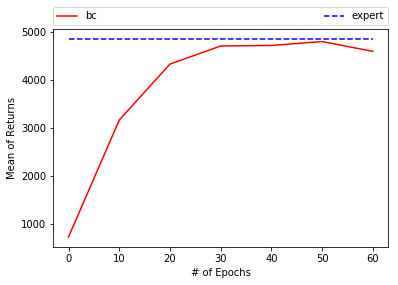

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure()
#plt.gcf().clear() 
x = np.arange(0, total_epochs, 10, dtype=int)
#plt.plot(x, bc, 'r-')
expert = np.repeat(expert[0], x.shape[0])
plt.plot(x, bc, 'r-', label="bc") 
plt.plot(x, expert, 'b--', label="expert")
plt.xlabel("# of Epochs")
plt.ylabel("Mean of Returns")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()
#plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
#sns.tsplot ( time=xdata , data= , color =’r’ , linestyle =’−’)

In [137]:
fig.savefig("p2q3.pdf", bbox_inches='tight')

In [190]:
# Dagger 
def train_model_dagger(task, epochs, dagger_steps):
    filename='expert_data/'+ task +'.pkl';
    print("Training for {}.".format(filename))
    o, a = load_expert_data(filename)
    a = a.reshape(a.shape[0], -1)
    train_ratio = 1.0
    valid_ratio = 0
    test_ratio = 0 
    train_index = int( train_ratio* o.shape[0])
    valid_index = int( valid_ratio* o.shape[0]) + train_index

    indices = np.random.permutation(o.shape[0])
    train_indices, valid_indices, test_indices = indices[:train_index], indices[train_index:valid_index], indices[valid_index:]
    o_train, o_valid, o_test = o[train_indices], o[valid_indices], o[test_indices]
    a_train, a_valid, a_test = a[train_indices], a[valid_indices], a[test_indices]
    print(o_train.shape)
    print(o_valid.shape)
    print(o_test.shape)
    model_name = task +'ckpt'
    
    dagger_returns = []
    
    tf_reset()
    with tf.Session() as sess:
        input_ph, output_ph, output_pred = create_model(o_train, a_train)
        
        # create loss
        mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))
        # create optimizer
        opt = tf.train.AdamOptimizer().minimize(mse)

        try:
            saver = tf.train.Saver()
            saver.restore(sess, "/tmp/1"+model_name)
        except ValueError:

            # initialize variables
            sess.run(tf.global_variables_initializer())
            # create saver to save model variables
            saver = tf.train.Saver()

            # run training
            batch_size = 64
            iterations = o_train.shape[0] // batch_size
            # run BC training
            for epoch_step in range(epochs):
                for training_step in range(iterations):
                    #print("training step %d" % training_step)
                    # get a random subset of the training data
                    indices = np.random.randint(low=0, high=o_train.shape[0], size=batch_size)
                    input_batch = o_train[indices]
                    output_batch = a_train[indices]

                    # run the optimizer and get the mse
                    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})

                # print the mse every so often
                print('epochs {0:02d} mse: {1:.3f}'.format(epoch_step, mse_run))
                saver.save(sess, '/tmp/'+model_name)
    
        my_model = tf_util.function([input_ph], output_pred)
        model_data = test_run(my_model, num_rollouts, task, expert_policy=False)
        dagger_returns.append(model_data['returns'])
        
    for dagger_step in range(dagger_steps):
        print("dagger step {}, o_train shape {}, a_train {}\n".format(dagger_step, o_train.shape, a_train.shape))
        tf_reset()
        with tf.Session() as sess:
            input_ph, output_ph, output_pred = create_model(o_train, a_train)
            # create loss
            mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))
            # create optimizer
            opt = tf.train.AdamOptimizer().minimize(mse)       
            # initialize variables
            # sess.run(tf.global_variables_initializer())
            # create saver to save model variables
            saver = tf.train.Saver()
            saver.restore(sess, "/tmp/"+model_name)
            
            # get a random subset of the training data
            # run training
            batch_size = 64
            iterations = o_train.shape[0] // batch_size
            # run BC training
            for epoch_step in range(epochs):
                for training_step in range(iterations):
                    #print("training step %d" % training_step)
                    # get a random subset of the training data
                    indices = np.random.randint(low=0, high=o_train.shape[0], size=batch_size)
                    input_batch = o_train[indices]
                    output_batch = a_train[indices]

                    # run the optimizer and get the mse
                    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
                
                # print the mse every so often
                #print('epochs {0:02d} mse: {1:.3f}'.format(epoch_step, mse_run))
                saver.save(sess, '/tmp/'+model_name)
                
            # run model
            my_model = tf_util.function([input_ph], output_pred)
            model_data = test_run(my_model, num_rollouts, task, expert_policy=False)
            dagger_returns.append(model_data['returns'])
            
            # get expert actions for observations
            obs = model_data['observations']
        tf_reset()
        with tf.Session() as sess:
            policy_fn = load_policy.load_policy('experts/'+task+'.pkl')
            actions = policy_fn(obs)
        actions = actions.reshape(actions.shape[0], -1)
        o_train = np.concatenate((o_train, obs), axis=0)
        a_train = np.concatenate((a_train, actions), axis=0)
    
    tf_reset()
    with tf.Session() as sess:
        policy_fn = load_policy.load_policy('experts/'+task+'.pkl')
        ref_return = test_run(policy_fn, num_rollouts, task, expert_policy=True)

#     model_mean, model_std = (np.mean(model_data['returns']), np.std(model_data['returns']))
#     ref_mean, ref_std =  (np.mean(ref_data['returns']), np.std(ref_data['returns']))
#     print(model_mean, ref_mean)
#     print(model_std, ref_std)
    return np.array(dagger_returns), ref_return['returns']

In [191]:
task = 'Humanoid-v2'
dagger_steps = 10
dagger, ref_return = train_model_dagger(task, 20, dagger_steps)
bc = np.tile(dagger[0], (dagger.shape[0],1))
expert = np.tile(ref_return, (dagger.shape[0],1))
print(bc)

Training for expert_data/Humanoid-v2.pkl.
(10000, 376)
(0, 376)
(0, 376)
epochs 00 mse: 1.233
epochs 01 mse: 0.864
epochs 02 mse: 0.378
epochs 03 mse: 0.666
epochs 04 mse: 0.375
epochs 05 mse: 0.406
epochs 06 mse: 0.374
epochs 07 mse: 0.630
epochs 08 mse: 0.325
epochs 09 mse: 0.324
epochs 10 mse: 0.125
epochs 11 mse: 0.154
epochs 12 mse: 0.193
epochs 13 mse: 0.717
epochs 14 mse: 0.105
epochs 15 mse: 0.309
epochs 16 mse: 0.141
epochs 17 mse: 0.111
epochs 18 mse: 0.207
epochs 19 mse: 0.073
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
returns [404.9104830853798, 333.4333914436927, 352.2121321398815, 307.2988602603872, 449.31991033239433, 274.3083474623214, 518.9169783258521, 562.3365909139054, 511.92409063701757, 301.22532824899525]
mean return 401.5886112849827
std of return 98.140649
dagger step 0, o_train shape (10000, 376), a_train (1

(11, 10)
(11,)


/Users/qijing.huang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/qijing.huang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/qijing.huang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


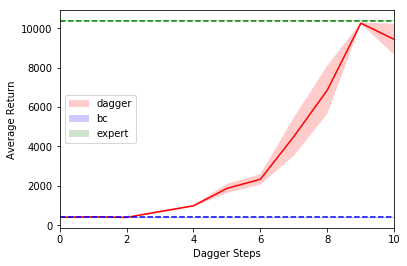

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure()

x = np.arange(0, dagger_steps+1, 1, dtype=int)
print(dagger.shape)
print(x.shape)
plt.gcf().clear() 
dagger_plot = sns.tsplot(time=x, data=np.transpose(dagger), color='r', linestyle='-')
bc_plot = sns.tsplot(time=x, data=np.transpose(bc), color='b', linestyle='--')
expert_plot = sns.tsplot(time=x, data=np.transpose(expert), color='g', linestyle='--')

plt.legend([dagger_plot, bc_plot, expert_plot], labels=["dagger", "bc", "expert"])

plt.ylabel("Average Return")
plt.xlabel("Dagger Steps")
# Legend .
# plt.legend(loc ='bottom left')

plt.show( )
fig.savefig("p3q3.pdf", bbox_inches='tight')